#DBScan clustering & Silhouette score,RMSE, Spatial Correlation Based evaluation


# Table of Contents

1.   Author(s)
2.   Purpose
3.   Keywords
4.   Citation
5.   Acknowledge
6.   Methodology
    * Installing Packages
    * Library Import
    * Read File
    * Transforming Data
    * Standardize features by removing the mean and scaling to unit variance.
    * RMSE
    * Evaluation - Spatial Correlation Coefficient

7. DBSCAN Clustering
    * How the clustering algorithm is applied to our dataset, such as deciding  cluster number and other parameters.
    * Trying Dbscan with different data

8. References

#1. Author(s) & Mentor(s)

Author1 = {"name": "Rohan Salvi", "email": "rsalvi2@umbc.edu"}

Mentor1 = {"name": "Dr. Xue Zheng ", "email": "zheng7@llnl.gov"}

Mentor2 = {"name": "Dr. Jianwu Wang ", "email": "jianwu@umbc.edu"}

#2. Purpose

In this research, we performed K-means & DBSCAN on a Geospatial Multivariate Data (4 dimensional: time, variables, longitude, latitude) 

Working on this project with collaboration of University of Maryland Baltimore County & Lawrence Livermore National Laboratory.

#3. Keywords

Include up to 5 keywords, using the template below.

keywords=["data cleaning", "Multivariate Dataset", "DBSCAN", "RMSE","Spatial Correlation", "Sillhouette Score"]

#4. Citation

Rohan Mandar Salvi, 2022. Multivariate weather data CLustering  .  At https://github.com/big-data-lab-umbc/multivariate-weather-data-clustering/

#5. Acknowledgements

 I would like to acknowledge Dr. Xue Zeng from Lawrence Livermore National Laboratory & Dr. Jianwu Wang from UMBC

#6. Methodology

#Installing packages


In [2]:
!pip install cftime
!pip install utils
!pip install netCDF4 
!pip install scipy
!pip install "xarray[io]"
!pip install geopandas
!pip install kneed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 185 kB 5.3 MB/s 
     |████████████████████████████████| 45 kB 4.1 MB/s 
     |████████████████████████████████| 19.3 MB 1.3 MB/s 
     |████████████████████████████████| 2.3 MB 44.5 MB/s 
     |████████████████████████████████| 56 kB 3.6 MB/s 
     |████████████████████████████████| 114 kB 64.7 MB/s 
     |████████████████████████████████| 6.6 MB 40.7 MB/s 
  Created wheel for eccodes: filename=eccodes-1.5.0-py3-none-any.whl size=39664 sha256=d1cf01514025ce48a

#Library import

In [3]:
#importing Libraries
import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 as nc
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import dask.dataframe as dd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics
from sklearn.metrics import v_measure_score


#Read File Mockv1, Mockv2.1, Mockv3, Mockv4 & Real-world Daily Data, Real-World Hourly Data


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
path1 = ('/content/drive/MyDrive/Multivariate Data Independent Study/mock.nc')
path2 = ('/content/drive/MyDrive/Multivariate Data Independent Study/mock_v2.1.nc')
path3 = ('/content/drive/MyDrive/Multivariate Data Independent Study/mock_v3.1.1.nc')
path4 = ('/content/drive/MyDrive/Multivariate Data Independent Study/mock_v4.nc')
path5 = ('/content/drive/MyDrive/Multivariate Data Independent Study/ERA5_meteo_sfc_2021_daily.nc')
path6 = ('/content/drive/MyDrive/Multivariate Data Independent Study/ERA5_meteo_sfc_2021_hourly.nc')
path6 = ('/content/drive/MyDrive/Multivariate Data Independent Study/rdata_hourly.csv')
path7 = ('/content/drive/MyDrive/Multivariate Data Independent Study/ERA5_meteo_sfc_2021_hourly_smalldomain.nc')
#data1 = xr.open_dataset(path2, decode_times=False) #To view the date as integers of 0, 1, 2,....
data1 = xr.open_dataset(path1) # To view time in datetime format
data2 = xr.open_dataset(path2)
data3 = xr.open_dataset(path3)
data4 = xr.open_dataset(path4)
data5 = xr.open_dataset(path5)
datat6 = pd.read_csv(path6)
data7 = xr.open_dataset(path7)

/usr/local/lib/python3.7/dist-packages/xarray/backends/plugins.py:68: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [6]:
datat6new=datat6.drop(columns=['Unnamed: 0'])

In [7]:
scaler = StandardScaler()
datat6_scaled = scaler.fit_transform(datat6new)

# Transforming Data & Standardizing  features by removing the mean and scaling to unit variance.


In [8]:
def transformddaily(x):
  import dask.dataframe
# Transforming Data
  dask_df = x.to_dask_dataframe(dim_order=None, set_index=False)
  dd = dask_df.compute()
  sst_data_trans = pd.DataFrame()
  t2m_data_trans = pd.DataFrame()
  v10_data_trans = pd.DataFrame()
  u10_data_trans = pd.DataFrame()
  sp_data_trans = pd.DataFrame()
  sshf_data_trans = pd.DataFrame()
  slhf_data_trans = pd.DataFrame()

  for i in range(0,dd.shape[0]):
    b=('sst'+'('+str(dd.latitude[i])+','+str(dd.longitude[i])+')')
    c=('t2m'+'('+str(dd.latitude[i])+','+str(dd.longitude[i])+')')
    d=('v10'+'('+str(dd.latitude[i])+','+str(dd.longitude[i])+')')
    e=('u10'+'('+str(dd.latitude[i])+','+str(dd.longitude[i])+')')
    f=('sp'+'('+str(dd.latitude[i])+','+str(dd.longitude[i])+')')
    g=('sshf'+'('+str(dd.latitude[i])+','+str(dd.longitude[i])+')')
    h=('slhf'+'('+str(dd.latitude[i])+','+str(dd.longitude[i])+')')

    sst_data_trans.loc[dd.time[i], b] = dd.sst[i]
    t2m_data_trans.loc[dd.time[i], c] = dd.t2m[i]
    v10_data_trans.loc[dd.time[i], d] = dd.v10[i]
    u10_data_trans.loc[dd.time[i], e] = dd.u10[i]
    sp_data_trans.loc[dd.time[i], f] = dd.sp[i]
    sshf_data_trans.loc[dd.time[i], g] = dd.sshf[i]
    slhf_data_trans.loc[dd.time[i], h] = dd.slhf[i]
#Removing Null Values
  sst_data_trans1 = sst_data_trans.values.astype(float)
  sst_data_trans1=sst_data_trans.fillna(9999)
  trans_concat = pd.concat([sst_data_trans1, t2m_data_trans, v10_data_trans, u10_data_trans, sp_data_trans, sshf_data_trans, slhf_data_trans ], axis=1)
  scaler = StandardScaler()
  trans_concat_scaled = scaler.fit_transform(trans_concat)
  return trans_concat_scaled

#Mock transform

In [9]:
def transformdmock(x):
  import dask.dataframe
# Transforming Data
  dask_df = x.to_dask_dataframe(dim_order=None, set_index=False)
  dd = dask_df.compute()
  sst_data_trans = pd.DataFrame()
  t2m_data_trans = pd.DataFrame()

  for i in range(0,dd.shape[0]):
    b=('sst'+'('+str(dd.lat[i])+','+str(dd.lon[i])+')')
    c=('t2m'+'('+str(dd.lat[i])+','+str(dd.lon[i])+')')

    sst_data_trans.loc[dd.time[i], b] = dd.sst[i]
    t2m_data_trans.loc[dd.time[i], c] = dd.t2m[i]

#Concating the variables 
  trans_concat = pd.concat([sst_data_trans, t2m_data_trans], axis=1)
  scaler = StandardScaler()
  trans_concat_scaled = scaler.fit_transform(trans_concat)
  return trans_concat_scaled

# 1 variable for Quater Map

In [10]:
def transformqm(x):
  import dask.dataframe
# Transforming Data
  dask_df = x.to_dask_dataframe(dim_order=None, set_index=False)
  dd = dask_df.compute()
  t2m_data_trans = pd.DataFrame()
  for i in range(0,dd.shape[0]):
    c=('t2m'+'('+str(dd.latitude[i])+','+str(dd.longitude[i])+')')
    t2m_data_trans.loc[dd.time[i], c] = dd.t2m[i]
#Removing Null Values
  trans_concat = pd.concat([t2m_data_trans ], axis=1)
  scaler = StandardScaler()
  trans_concat_scaled = scaler.fit_transform(trans_concat)
  return trans_concat_scaled

In [11]:
datat1= transformdmock(data1)
datat2=transformdmock(data2)
datat3=transformdmock(data3)
datat4=transformdmock(data4)
datat5=transformddaily(data5)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1684: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = infer_fill_value(value)


In [ ]:
data7 = xr.open_dataset(path7)
datat7 = transformddaily(data7)

In [13]:
datat7 = pd.read_csv('/content/drive/MyDrive/Multivariate Data Independent Study/ERA5_meteo_sfc_2021_hourly_smalldomain.csv')

In [ ]:
pd.DataFrame(datat7).to_csv("ERA5_meteo_sfc_2021_hourly_smalldomain.csv")

#RMSE

In [14]:
# Non-normalized
# Function that creates a dictionary that holds the values of dates in each cluster
def get_datewise_clusters(formed_clusters): # classification
  Dates_Cluster = {}
  for i in set(formed_clusters): # classification
    Dates_Cluster['Dates_Cluster'+str(i)] = trans_data.index[trans_data.Cluster == i].to_list()
  return Dates_Cluster

In [15]:
# Non-normalized
# Function that creats a dictionary that holds all the clusters
def n_nor_get_clusters(input,formed_clusters): # classification
  com_arr = []
  Clusters = {}
  Dates_Cluster = get_datewise_clusters(formed_clusters)
  for i in set(formed_clusters):
    for j in Dates_Cluster['Dates_Cluster'+str(i)]:
      arr = np.array(input.isel(time=j).to_array()) # input is data
      com_arr.append(arr)
    Clusters['Cluster' + str(i)] = np.array(com_arr)
    com_arr = []
  return Clusters    

In [16]:
# Non-normalized
# Function that creates a dictionary that holds all the cluster centers
def n_nor_get_cluster_centers(input,formed_clusters): #classification
  Cluster_Centers = {}
  Clusters = n_nor_get_clusters(input,formed_clusters)
  for i in set(formed_clusters):
    Cluster_Centers['Cluster_Center' + str(i)] = np.mean(Clusters['Cluster' + str(i)],axis=0)
  return Cluster_Centers

In [17]:
# Non-normalized
def handle_missing_values(input):
  var_mean = {}
  for i in input.data_vars:
    if input[i].isnull().sum().item() > 0:
      print(i,'has null values')
      var_mean[str(i) + '_mean'] = input[i].mean().item()
      input[i] = input[i].fillna(var_mean[str(i) + '_mean'])
  return input

In [18]:
# Non-normalized 
#Intra RMSE Calculation Function
def n_nor_intra_rmse(input,formed_clusters):
  sq_diff = []
  intra_rmse = []
  Clusters = n_nor_get_clusters(input,formed_clusters)
  Cluster_Centers = n_nor_get_cluster_centers(input,formed_clusters)

  for i in range(len(Clusters)):
    for j in range(len(Clusters['Cluster' + str(i)])):
      diff = Clusters['Cluster' + str(i)][j] - Cluster_Centers['Cluster_Center' + str(i)]
      Sq_diff = (diff**2)
      sq_diff.append(Sq_diff)
    Sq_diff_sum = sum(sq_diff)
    sq_diff = []
    n = len(Clusters['Cluster' + str(i)])
    Sqrt_diff_sum = np.sqrt(sum(sum(sum(Sq_diff_sum/n))))
    intra_rmse.append(Sqrt_diff_sum)
  return intra_rmse

In [19]:
# Normalized
# Function that creates two dictionaries that hold all the clusters and cluster centers
def nor_get_clusters_and_centers(input,formed_clusters):
  Clusters = {}
  Cluster_Centers = {}
  for i in set(formed_clusters):
    Clusters['Cluster' + str(i)] = np.array(input[input.Cluster == i].drop(columns=['Cluster']))
    Cluster_Centers['Cluster_Center' + str(i)] = np.mean(Clusters['Cluster' + str(i)],axis=0)
  return Clusters,Cluster_Centers

In [20]:
# Normalized
# Intra RMSE Calculation Function
def nor_intra_rmse(input,formed_clusters):
  intra_rmse = []
  sq_diff = []
  Clusters,Cluster_Centers = nor_get_clusters_and_centers(input,formed_clusters)
  for i in range(len(Clusters)):
    for j in range(len(Clusters['Cluster' + str(i)])):
      diff = Clusters['Cluster' + str(i)][j] - Cluster_Centers['Cluster_Center' + str(i)]
      Sq_diff = (diff**2)
      sq_diff.append(Sq_diff)
    Sq_diff_sum = sum(sum(sq_diff))
    sq_diff = []
    n = len(Clusters['Cluster' + str(i)])
    Sqrt_diff_sum = np.sqrt(Sq_diff_sum/n)
    intra_rmse.append(Sqrt_diff_sum)
  return intra_rmse

In [21]:
# Non-normalized
# Function that creates a dictionary that holds all the cluster centers
def n_nor_get_cluster_centers(input,formed_clusters): #classification
  Cluster_Centers = {}
  Clusters = n_nor_get_clusters(input,formed_clusters)
  for i in set(formed_clusters):
    Cluster_Centers['Cluster_Center' + str(i)] = np.mean(Clusters['Cluster' + str(i)],axis=0)
  return Cluster_Centers

In [22]:
# RMSE Calculation
def RMSE(input,formed_clusters,frame,normalize=False):
  inter_rmse = []
  avg_cluster = {}

  if normalize == False:
    input = handle_missing_values(input)
    Clusters = n_nor_get_clusters(input,formed_clusters)
    mat = pd.DataFrame(columns=range(len(Clusters)),index=range(len(Clusters)))
    for i in range(len(Clusters)):
      avg_cluster['avg_cluster'+str(i)] = np.mean(Clusters['Cluster' + str(i)],axis=0)
    for i in range(len(Clusters)):
      for j in range(len(Clusters)):
        if i == j:
          a = n_nor_intra_rmse(input,formed_clusters)
          mat[i].iloc[j] = round(a[i],2)
        else:
          diff = avg_cluster['avg_cluster' + str(i)] - avg_cluster['avg_cluster' + str(j)]
          Sq_diff = (diff**2)
          #Sq_diff_sum = sum(Sq_diff)
          Sq_diff_sum = sum(sum(sum(Sq_diff)))
          #inter_rmse.append(np.sqrt(Sq_diff_sum))
          n = len(avg_cluster['avg_cluster'+str(i)][0])
          Sqrt_diff_sum = np.sqrt(Sq_diff_sum/n)
          mat[i].iloc[j] = round(Sqrt_diff_sum,2)
          #print('Inter RMSE between cluster',i,'and cluster',j,'is:',inter_rmse.pop())
        

  else:

  
    Clusters, Cluster_Centers = nor_get_clusters_and_centers(frame,formed_clusters)

    # Doing the below step after finding the cluster centers. Otherwise, we'll be calculating mean on date (index) too.
    #trans_data = trans_data.reset_index()

  
    mat = pd.DataFrame(columns=range(len(Clusters)),index=range(len(Clusters)))
    for i in range(len(Clusters)):
      avg_cluster['avg_cluster'+str(i)] = np.mean(Clusters['Cluster' + str(i)],axis=0)
    for i in range(len(Clusters)):
      for j in range(len(Clusters)):
        if i == j:
          a = nor_intra_rmse(frame,formed_clusters)
          mat[i].iloc[j] = round(a[i],2)
        else:
          diff = avg_cluster['avg_cluster' + str(i)] - avg_cluster['avg_cluster' + str(j)]
          Sq_diff = (diff**2)
          #Sq_diff_sum = sum(Sq_diff)
          Sq_diff_sum = sum(Sq_diff)
          #inter_rmse.append(np.sqrt(Sq_diff_sum))
          Sqrt_diff_sum = np.sqrt(Sq_diff_sum)
          mat[i].iloc[j] = round(Sqrt_diff_sum,2)
          #print('Inter RMSE between cluster',i,'and cluster',j,'is:',inter_rmse.pop())

  return mat

#**Evaluation - Spatial Correlation Coefficient**


In [23]:
#For Spatial Correlation coefficient computation
'''
   Input parameters: 
   X : An array, A 2-D array containing multiple variables and observations. 
   Y : An array, A 2-D array containing multiple variables and observations. 
   Each row of x represents a variable, and each column a single observation of all those variables.

   Returns: Pearson product-moment correlation coefficients.:A scaler quantity [-1, 1] 
   where -1 means the inputs are inversly correlated(opposite movements) 
   and 1 means directly correlated (unidirectional parallel movement) 
   while 0 means no correlation.
   
'''


def pearson_PM(x, y):

  #convert format from netcdf to np array
    #x_form = x.to_numpy()
    #y_form = y.to_numpy()

    #Flatten/transform from 2d to 1d
    X_flat = x.flatten()
    Y_flat = y.flatten()

    #Compute correlation matrix
    corr_mat = np.corrcoef(X_flat, Y_flat)

    #Return entry [0,1]
    return corr_mat[0,1]

def corr_space_2d(var1_2d,var2_2d):
    var1= np.reshape(var1_2d,var1_2d.shape[0]*var1_2d.shape[1])
    var2= np.reshape(var2_2d,var2_2d.shape[0]*var2_2d.shape[1])
    R0=np.corrcoef(var1,var2)
    if(R0.shape !=(2,2)):
        #print("corr_space_2d error: corrcoef maxtrix R0 :",R0)
        stop
    R = R0[0,1]
    return R

In [24]:
def Average(lst):
  for i in lst:
    return sum(lst) / len(lst)

# Non-normalized

In [25]:
#Intra-spatial correlation coefficient Calculation Function
def n_nor_intra_sp_corr(input,formed_clusters):
  mylist = []
  intra_sp_corr = []
  Clusters = n_nor_get_clusters(input,formed_clusters)

  for i in range(len(Clusters)):
    for j in range(len(Clusters['Cluster' + str(i)])):
      for k in range(len(Clusters['Cluster' + str(i)])):
        corr_coeff = pearson_PM(Clusters['Cluster' + str(i)][j],  Clusters['Cluster' + str(i)][k])
        mylist.append(corr_coeff)

    corr = Average(mylist)
    intra_sp_corr.append(corr)
  return intra_sp_corr

In [26]:
#Inter-spatial correlation coefficient Calculation Function
def n_nor_inter_sp_corr1(input,formed_clusters):
  mylist = []
  inter_sp_corr = []
  Clusters = n_nor_get_clusters(input,formed_clusters)

  for i in range(len(Clusters)):
    for j in range(len(Clusters)):
      for k in range(len(Clusters['Cluster' + str(i)])):
        for l in range(len(Clusters['Cluster' + str(j)])):
          if i != j:
            corr_coeff = pearson_PM(Clusters['Cluster' + str(i)][k],  Clusters['Cluster' + str(j)][l])
            mylist.append(corr_coeff)

    corr = Average(mylist)
    inter_sp_corr.append(corr)
  return inter_sp_corr

## Normalized Approach

In [27]:
def nor_get_clusters(input,formed_clusters):
  Clusters = {}
  for i in set(formed_clusters):
    Clusters['Cluster' + str(i)] = np.array(input[input.Cluster == i].drop(columns=['Cluster']))
  return Clusters

In [28]:
# Normalized
#Intra-spatial correlation coefficient Calculation Function
def nor_intra_sp_corr(input,formed_clusters):
  ''' Rather than passing transformed data to the function, you could use the below steps to transform the data first and later add 
      'Cluster' as a column to the transformed data'''
  # input = datatransformation(input)
  # input = datanormalization(input)
  # input['Cluster'] = formed_clusters
  mylist1 = []
  intra_sp_corr = []
  Clusters = nor_get_clusters(input,formed_clusters)

  for i in range(len(Clusters)):
    for j in range(len(Clusters['Cluster' + str(i)])):
      for k in range(len(Clusters['Cluster' + str(i)])):
        corr_coeff = pearson_PM(Clusters['Cluster' + str(i)][j],  Clusters['Cluster' + str(i)][k])
        mylist1.append(corr_coeff)
        
    corr = Average(mylist1)
    intra_sp_corr.append(corr)
  return intra_sp_corr

In [29]:
# Normalized 
#Inter-spatial correlation coefficient Calculation Function
def nor_inter_sp_corr1(input,formed_clusters):
  # input = datatransformation(input)
  # input = datanormalization(input)
  # input['Cluster'] = formed_clusters
  mylist = []
  inter_sp_corr = []
  Clusters = nor_get_clusters(input,formed_clusters)

  for i in range(len(Clusters)):
    for j in range(len(Clusters)):
      for k in range(len(Clusters['Cluster' + str(i)])):
        for l in range(len(Clusters['Cluster' + str(j)])):
          if i != j:
            corr_coeff = pearson_PM(Clusters['Cluster' + str(i)][k],  Clusters['Cluster' + str(j)][l])
            mylist.append(corr_coeff)
            
    corr = Average(mylist)
    inter_sp_corr.append(corr)
  return inter_sp_corr

In [30]:
# Spat_Corr Calculation
def Spat_Corr(input,formed_clusters,trans_data,normalize=False):
  inter_sp_corr = []
  mylist = []

  if normalize == False:
    input = handle_missing_values(input)
    Clusters = n_nor_get_clusters(input,formed_clusters)
    mat = pd.DataFrame(columns=range(len(Clusters)),index=range(len(Clusters)))

    for i in range(len(Clusters)):
      for j in range(len(Clusters)):
        for k in range(len(Clusters['Cluster' + str(i)])):
          for l in range(len(Clusters['Cluster' + str(j)])):
            if i == j:
              a = n_nor_intra_sp_corr(input,formed_clusters)
              mat[i].iloc[j] = a[i]
            else:
              results = n_nor_inter_sp_corr1(input,formed_clusters)
              mat[i].iloc[j] = Average(results)
        

  else:
    #trans_data = datatransformation(input)

    # Data Normalization
    #trans_data = datanormalization(trans_data)

    # Adding class centers and cluster numbers as columns to the dataframe
   # trans_data['Cluster'] = classification

    # Rearranging the columns in the dataframe
    #trans_data = trans_data[['Cluster'] + [c for c in trans_data if c not in ['Cluster']]]
  
    Clusters, Cluster_Centers = nor_get_clusters_and_centers(trans_data,formed_clusters)

    #Clusters = n_nor_get_clusters(input,formed_clusters)
    #trans_data = trans_data.reset_index()

  
    mat = pd.DataFrame(columns=range(len(Clusters)),index=range(len(Clusters)))

    for i in range(len(Clusters)):
      for j in range(len(Clusters)):
        for k in range(len(Clusters['Cluster' + str(i)])):
          for l in range(len(Clusters['Cluster' + str(j)])):
            if i == j:
              a = nor_intra_sp_corr(trans_data,formed_clusters)
              mat[i].iloc[j] = a[i]
            else:
              results = nor_inter_sp_corr1(trans_data,formed_clusters)
              mat[i].iloc[j] = Average(results) 
  return mat

#6. DBSCAN Clustering

DBSCAN stands for Density-Based Spatial Clustering of Applications with Noise. It is a part of unsupervised learning . 
It is very sensitive to input parameters. It depends on a single value of epsilon for all clusters, and therefore, clusters with variable densities may not be correctly identified by dbscan. 

*   The advantage of DBSCAN is that it identifies an extra group of outliers.

#How the clustering algorithm is applied to our dataset, such as deciding cluster number and other parameters

Epsilon Value (eps)
Epsilon is the circumference of a circle around a data point, within which all other data points are regarded as nearby points. In other words, if the distance between two points is less than or equal to eps, they are said to be neighbors.

EXTREMELY SMALL VALUE
Most of the points may not be in the neighborhood and will be considered outliers if the eps value is * extremely small* . As a result, there will be poor clustering because the majority of the points do not meet the minimal number of points needed to form a dense region.

VERY HIGH VALUE
However, if a *very high value *is selected, the majority of the data points will stay in the same cluster. Once again, this will result in poor clustering, where multiple clusters may end up merging as a result of the high value of epsilon.

Although small eps values are typically preferred, in theory we must choose the eps value based on the dataset's distance (using a k-distance graph).

#MOCK data DBSCAN

In [31]:
def dbscanmock(x):
      db = DBSCAN().fit(x) #I did not require to add any parameters to dbscan with mock data. The default parameters were enough for dbscan .
      core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
      core_samples_mask[db.core_sample_indices_] = True
      labels = db.labels_

      # Number of clusters in labels, ignoring noise if present.
      n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
      n_noise_ = list(labels).count(-1)
      frame = pd.DataFrame(x)
      frame['Cluster'] = labels
      frame['Cluster'].value_counts()
      print("Estimated number of clusters: %d" % n_clusters_)
      print(frame['Cluster'].value_counts())
      print("Estimated number of noise points: %d" % n_noise_)
      print("Silhouette Coefficient: %0.3f" % silhouette_score(x, labels))
      return frame,labels

#Mock.nc Dbscan


In [32]:
frame1,label1=dbscanmock(datat1)
print(label1)

Estimated number of clusters: 2
0    10
1    10
Name: Cluster, dtype: int64
Estimated number of noise points: 0
Silhouette Coefficient: 1.000
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]


In [ ]:
print("RMSE | Normalized with Mock.nc")
final1 = RMSE(data1,label1,frame1,True)
final1

RMSE | Normalized with Mock.nc


,0,1
0,0.0,28.28
1,28.28,0.0


In [ ]:
trans_data=frame1
print("RMSE | Non-Normalized with Mock.nc")
final2 = RMSE(data1,label1,frame1,False)
final2

RMSE | Non-Normalized with Mock.nc


,0,1
0,0.0,314.66
1,314.66,0.0


In [ ]:
print("Spatial_Correlation | Normalized with Mock.nc")
trans_data=frame1
final4 = Spat_Corr(data1,label1,frame1,True)
final4

Spatial_Correlation | Normalized with Mock.nc


,0,1
0,1.0,-1.0
1,-1.0,1.0


In [ ]:
print("Spatial_Correlation | Non-Normalized with Mock.nc")
trans_data=frame1
final4 = Spat_Corr(data1,label1,frame1,False)
final4

Spatial_Correlation | Non-Normalized with Mock.nc


,0,1
0,1.0,-1.0
1,-1.0,1.0


#Mock_v2.1 Dbscan


In [ ]:
frame2,label2=dbscanmock(datat2)
print(label2)


Estimated number of clusters: 2
0    10
1    10
Name: Cluster, dtype: int64
Estimated number of noise points: 0
Silhouette Coefficient: 1.000
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]


In [ ]:
print("RMSE | Normalized with Mockv2.1.nc")
final1 = RMSE(data2,label2,frame2,True)
final1

RMSE | Normalized with Mockv2.1.nc


,0,1
0,0.0,28.28
1,28.28,0.0


In [ ]:
trans_data=frame2
print("RMSE | Non-Normalized with Mockv2.1.nc")
final2 = RMSE(data2,label2,frame2,False)
final2

RMSE | Non-Normalized with Mockv2.1.nc


,0,1
0,0.0,248.61
1,248.61,0.0


In [ ]:
print("Spatial_Correlation | Normalized with Mock2.1.nc")
trans_data=frame2
final4 = Spat_Corr(data2,label2,frame2,True)
final4

Spatial_Correlation | Normalized with Mock2.1.nc


,0,1
0,1.0,-1.0
1,-1.0,1.0


In [ ]:
print("Spatial_Correlation |  Non-Normalized with Mockv2.1.nc")
trans_data=frame2
final4 = Spat_Corr(data2,label2,frame2,False)
final4

Spatial_Correlation |  Non-Normalized with Mockv2.1.nc


,0,1
0,1.0,-0.812811
1,-0.812811,1.0



#Mock_v3.1.1 Dbscan

In [ ]:
frame3,label3=dbscanmock(datat3)
print(label3)


Estimated number of clusters: 4
0    5
1    5
2    5
3    5
Name: Cluster, dtype: int64
Estimated number of noise points: 0
Silhouette Coefficient: 1.000
[0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3]


In [ ]:
print("RMSE | Normalized")
final1 = RMSE(data3,label3,frame3,True)
final1

RMSE | Normalized


,0,1,2,3
0,0.0,6.33,27.61,26.9
1,6.33,0.0,26.9,27.61
2,27.61,26.9,0.0,13.71
3,26.9,27.61,13.71,0.0


In [ ]:
trans_data=frame3
print("RMSE | Non-Normalized")
final1 = RMSE(data3,label3,frame3,False)
final1

RMSE | Non-Normalized


,0,1,2,3
0,0.0,16.12,497.52,498.27
1,16.12,0.0,498.27,497.52
2,497.52,498.27,0.0,316.62
3,498.27,497.52,316.62,0.0


In [ ]:
print("Spatial_Correlation | Normalized with Mock3.1.1.nc")
trans_data=frame3
final4 = Spat_Corr(data3,label3,frame3,True)
final4

Spatial_Correlation | Normalized with Mock3.1.1.nc


,0,1,2,3
0,1.0,-0.299768,-0.299768,-0.299768
1,-0.299768,1.0,-0.299768,-0.299768
2,-0.299768,-0.299768,1.0,-0.299768
3,-0.299768,-0.299768,-0.299768,1.0


In [ ]:
print("Spatial_Correlation |  Non-Normalized with Mockv3.1.1.nc")
trans_data=frame3
final4 = Spat_Corr(data3,label3,frame3,False)
final4

Spatial_Correlation |  Non-Normalized with Mockv3.1.1.nc


,0,1,2,3
0,1.0,-0.351228,-0.351228,-0.351228
1,-0.351228,1.0,-0.351228,-0.351228
2,-0.351228,-0.351228,1.0,-0.351228
3,-0.351228,-0.351228,-0.351228,1.0


#Mock_v4 Dbscan

In [ ]:
frame4,label4=dbscanmock(datat4)
print(label4)

Estimated number of clusters: 4
0    5
1    5
2    5
3    5
Name: Cluster, dtype: int64
Estimated number of noise points: 0
Silhouette Coefficient: 1.000
[0 0 0 0 0 1 1 1 1 1 2 2 2 2 2 3 3 3 3 3]


In [ ]:
print("RMSE | Normalized")
final1 = RMSE(data4,label4,frame4,True)
final1

RMSE | Normalized


,0,1,2,3
0,0.0,2.99,28.03,28.06
1,2.99,0.0,28.05,28.2
2,28.03,28.05,0.0,5.96
3,28.06,28.2,5.96,0.0


In [ ]:
trans_data=frame4
print("RMSE | Non-Normalized")
final1 = RMSE(data4,label4,frame4,False)
final1


RMSE | Non-Normalized


,0,1,2,3
0,0.0,6.84,354.6,354.79
1,6.84,0.0,354.79,354.79
2,354.6,354.79,0.0,134.33
3,354.79,354.79,134.33,0.0


In [ ]:
print("Spatial_Correlation | Normalized with Mock4.nc")
trans_data=frame4
final4 = Spat_Corr(data4,label4,frame4,True)
final4

Spatial_Correlation | Normalized with Mock4.nc


,0,1,2,3
0,1.0,-0.326961,-0.326961,-0.326961
1,-0.326961,1.0,-0.326961,-0.326961
2,-0.326961,-0.326961,1.0,-0.326961
3,-0.326961,-0.326961,-0.326961,1.0


In [ ]:
print("Spatial_Correlation |  Non-Normalized with Mockv4.nc")
trans_data=frame4
final4 = Spat_Corr(data4,label4,frame4,False)
final4

Spatial_Correlation |  Non-Normalized with Mockv4.nc


,0,1,2,3
0,1.0,-0.292527,-0.292527,-0.292527
1,-0.292527,1.0,-0.292527,-0.292527
2,-0.292527,-0.292527,1.0,-0.292527
3,-0.292527,-0.292527,-0.292527,1.0


#Real-World DATA

Figuring the parameters of dbscan is a bit difficult for real- world Data. So there are various ways I tried to figure out .

First way and the recommended way of finding the Optimal value of Epsilon is the elbow point detection method to arrive at a suitable value of epsilon.

#Elbow-Point Detection Method with Multivariate Daily-Real-World Data 

In this method, the average distance between each point and its k closest neighbors—k being the MinPts that we chose—is calculated. We then create a k-distance graph and plot the average k-distances in ascending order.

The point with the greatest bend or curvature, or the steepest slope, is where epsilon should be set to its ideal value.

Below is a function for finding the knee point

In [ ]:
def nearest(x):
    neighbors = NearestNeighbors(n_neighbors=5)
    neighbors_fit = neighbors.fit(x)
    distances, indices = neighbors_fit.kneighbors(x)
    distances = np.sort(distances[:,4], axis=0)
    #plt.plot(distances)
    return distances

In [ ]:
def kneenearest(data):
    i = np.arange(len(nearest(data)))
    knee = KneeLocator(i, nearest(data), S=1, curve='convex', direction='increasing', interp_method='polynomial')
    fig = plt.figure(figsize=(5, 5))
    knee.plot_knee()
    plt.xlabel("Points")
    plt.ylabel("K-NN Distance")
    print(nearest(data)[knee.knee])
    return 

77.43643036290842


<Figure size 360x360 with 0 Axes>

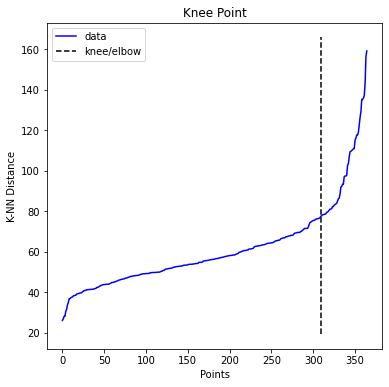

In [ ]:
kneenearest(datat5)

Visually locating the maximum curvature can be challenging. Therefore, the knee or elbow point can be found using the kneed Python package. 'pip install kneed' can be used to install this.
The elbow point is now visible using the package below, and we will use this value of epsilon as it is the best one. This value is 77.43643036290842.

Optimal number of min_samples based on silhouette score: [5]


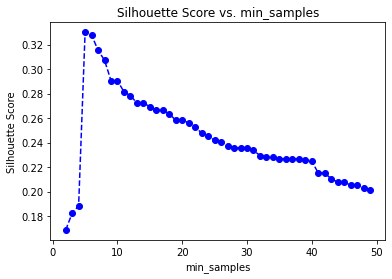

In [ ]:
# Silhouette Score for DBSCAN

def get_dbscan_score(data, center):
    ''' 
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the Silhouette Score for DBSCAN
    '''
    #instantiate kmeans
    dbscan = DBSCAN(eps=76, min_samples=center)

    # Then fit the model to your data using the fit method
    model = dbscan.fit(datat5)
    
    # Calculate Silhoutte Score

    score = silhouette_score(datat5, model.labels_, metric='euclidean')
    
    return score

scores = []
centers = list(range(2,50)) #min_samples will be checked from range  2 - 50

for center in centers:
    scores.append(get_dbscan_score(datat5, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('min_samples');
plt.ylabel('Silhouette Score');
plt.title('Silhouette Score vs. min_samples');

df3 = pd.DataFrame(centers,columns=['min_samples'])
df3['scores'] = scores
df4 = df3[df3.scores == df3.scores.max()]
print('Optimal number of min_samples based on silhouette score:', df4['min_samples'].tolist())

In [34]:
def dbscanner(data,eps,min_sam):
    dbscan_cluster = DBSCAN(eps=eps, min_samples=min_sam)
    db = dbscan_cluster.fit(data)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    frame = pd.DataFrame(data)
    frame['Cluster'] = labels
    frame['Cluster'].value_counts()
    print("Estimated number of clusters: %d" % n_clusters_)
    print(frame['Cluster'].value_counts())
    print("Estimated number of noise points: %d" % n_noise_)
    print("Silhouette Coefficient: %0.3f" % silhouette_score(data, labels))
    return

In [40]:
dbscanner(datat5,76,5)

Estimated number of clusters: 1
 0    328
-1     37
Name: Cluster, dtype: int64
Estimated number of noise points: 37
Silhouette Coefficient: 0.330


Optimal number of min_sample based on Calinski Harabasz score: [28, 29]


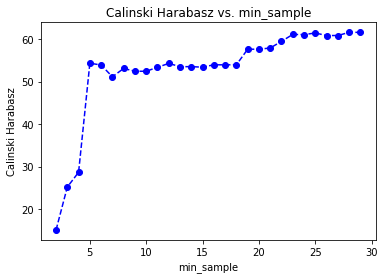

In [ ]:
# Calinski Harabasz for DBSCAN

from sklearn.metrics import calinski_harabasz_score  
def get_dbscan_score(data, center):
    ''' 
    INPUT:
        data - the dataset you want to fit dbscan to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the Calinski Harabasz score for the dbscan model fit to the data
    '''
    #instantiate dbscan
    dbscan = DBSCAN(eps= 76, min_samples=center)

    # Then fit the model to your data using the fit method
    model = dbscan.fit(datat5)
    
    # Calculate Silhoutte Score

    score = calinski_harabasz_score(datat5, dbscan.labels_)
    
    return score

scores = []
centers = list(range(2,30))

for center in centers:
    scores.append(get_dbscan_score(datat5, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('min_sample');
plt.ylabel('Calinski Harabasz');
plt.title('Calinski Harabasz vs. min_sample');

df3 = pd.DataFrame(centers,columns=['min_sample'])
df3['scores'] = scores
df4 = df3[df3.scores == df3.scores.max()]
print('Optimal number of min_sample based on Calinski Harabasz score:', df4['min_sample'].tolist())

In [ ]:
dbscanner(datat5,76,29)

Estimated number of clusters: 1
 0    272
-1     93
Name: Cluster, dtype: int64
Estimated number of noise points: 93
Silhouette Coefficient: 0.236


Optimal number of min_samples based on DB score: [2]


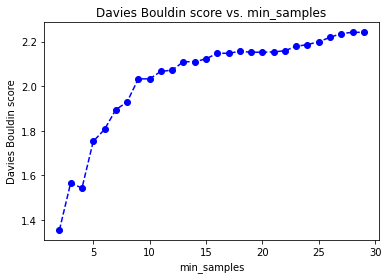

In [ ]:
# Davies Bouldin score for DBSCAN

from sklearn.metrics import davies_bouldin_score 

def get_dbscan_score(data, center):
    '''
    returns the dbscan score regarding Davies Bouldin for points to centers
    INPUT:
        data - the dataset you want to fit dbscan to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the Davies Bouldin score for the dbscan model fit to the data
    '''
    #instantiate dbscan
    dbscan = DBSCAN(eps= 76, min_samples=center)

    # Then fit the model to your data using the fit method
    model = dbscan.fit_predict(datat5)
    
    # Calculate Silhoutte Score

    score = davies_bouldin_score(datat5, model)
    
    return score

scores = []
centers = list(range(2,30))

for center in centers:
    scores.append(get_dbscan_score(datat5, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('min_samples');
plt.ylabel('Davies Bouldin score');
plt.title('Davies Bouldin score vs. min_samples');


df3 = pd.DataFrame(centers,columns=['min_samples'])
df3['scores'] = scores
df4 = df3[df3.scores == df3.scores.min()]
print('Optimal number of min_samples based on DB score:', df4['min_samples'].tolist())

In [ ]:
dbscanner(datat5,76,2)

Estimated number of clusters: 4
 0    335
-1     22
 1      4
 2      2
 3      2
Name: Cluster, dtype: int64
Estimated number of noise points: 22
Silhouette Coefficient: 0.169


#Real-World Data Hourly

#Elbow-Point Detection Method with Multivariate Hourly-Real-World Data

26.735690964419295


<Figure size 360x360 with 0 Axes>

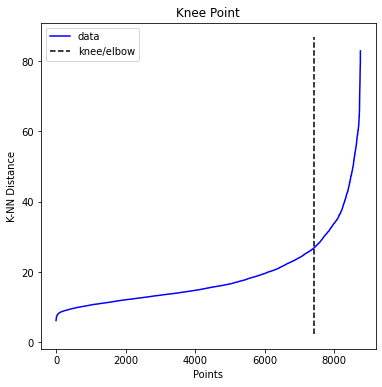

In [ ]:
kneenearest(datat6_scaled)

In [ ]:
min_samples = 4  #range(1,20)

#eps = np.arange(0.05,0.13, 0.01) # returns array of ranging from 0.05 to 0.13 with step of 0.01
eps = range(10,20)

In [ ]:
from sklearn.metrics import silhouette_score

output = []

#for ms in min_samples:
for ep in eps:
        labels = DBSCAN(min_samples=4, eps=ep).fit(datat7).labels_
        score = silhouette_score(datat7, labels)
        output.append(( eps))
        print('*******')
        print("Score:")
        print(score)
        print(ep)
        #print(np.unique(labels))
        #print(labels)

*******
Score:
-0.8487035816817023
4
*******
Score:
-0.601114341061828
5
*******
Score:
-0.3590762915021501
6
*******
Score:
-0.20367547337485406
7
*******
Score:
-0.09178262487501729
8
*******
Score:
-0.025624901414674488
9
*******
Score:
0.05261578830645636
10
*******
Score:
0.051159338789045966
11
*******
Score:
0.09568168040049707
12
*******
Score:
0.11150491492386304
13
*******
Score:
0.1404794809545786
14
*******
Score:
0.1694221542509476
15
*******
Score:
0.1507951690223019
16
*******
Score:
0.08044282980060352
17
*******
Score:
0.13184233955306077
18
*******
Score:
0.12728373960354344
19


Optimal number of min_sample based on Calinski Harabasz score: [4]


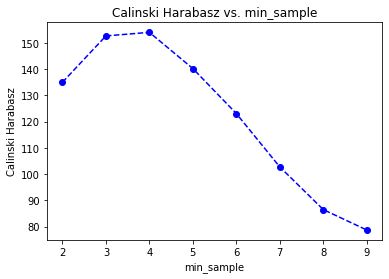

In [ ]:
# Calinski Harabasz for DBSCAN

from sklearn.metrics import calinski_harabasz_score  

def get_dbscan_score(data, center):
    '''
    
    INPUT:
        data - the dataset you want to fit dbscan to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the Calinski Harabasz score for the dbscan model fit to the data
    '''
    #instantiate dbscan
    dbscan = DBSCAN(eps= 27, min_samples=center)

    # Then fit the model to your data using the fit method
    model = dbscan.fit(datat6_scaled)
    
    # Calculate Silhoutte Score

    score = calinski_harabasz_score(datat6_scaled, dbscan.labels_)
    
    return score

scores = []
centers = list(range(2,10))

for center in centers:
    scores.append(get_dbscan_score(datat6_scaled, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('min_sample');
plt.ylabel('Calinski Harabasz');
plt.title('Calinski Harabasz vs. min_sample');

df3 = pd.DataFrame(centers,columns=['min_sample'])
df3['scores'] = scores
df4 = df3[df3.scores == df3.scores.max()]
print('Optimal number of min_sample based on Calinski Harabasz score:', df4['min_sample'].tolist())

In [ ]:
dbscanner(datat6_scaled,27,4)

Estimated number of clusters: 60
 41    2169
-1      900
 35     773
 43     529
 44     436
       ... 
 36       6
 24       6
 51       5
 20       5
 21       5
Name: Cluster, Length: 61, dtype: int64
Estimated number of noise points: 900
Silhouette Coefficient: -0.060


#Conclusion of Hourly and Daily Data 

#**************Real-World Data with Quater Map************


Trying out the elbow knee method to figure out the eps and then trying out the for loop in range for figuring out the min_sample.

14.249051832166948


<Figure size 360x360 with 0 Axes>

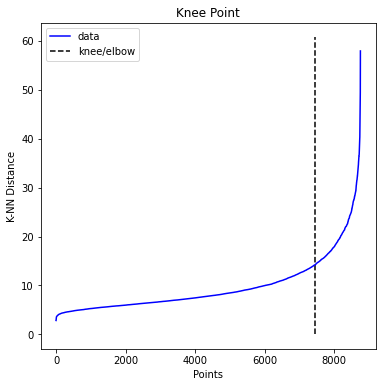

In [ ]:
kneenearest(datat7)

Optimal number of min_samples based on silhouette score: [4]


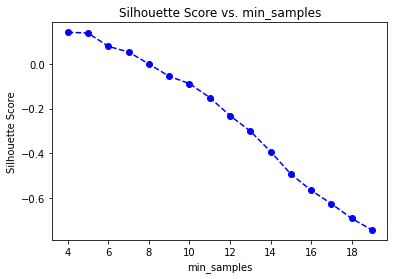

In [ ]:
# Silhouette Score for DBSCAN

def get_dbscan_score(data, center):
    '''
    
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the Silhouette Score for DBSCAN
    '''
    #instantiate kmeans
    dbscan = DBSCAN(eps=14, min_samples=center)

    # Then fit the model to your data using the fit method
    model = dbscan.fit(datat7)
    
    # Calculate Silhoutte Score

    score = silhouette_score(datat7, model.labels_, metric='euclidean')
    
    return score

scores = []
centers = list(range(4,20))

for center in centers:
    scores.append(get_dbscan_score(datat7, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('min_samples');
plt.ylabel('Silhouette Score');
plt.title('Silhouette Score vs. min_samples');

df3 = pd.DataFrame(centers,columns=['min_samples'])
df3['scores'] = scores
df4 = df3[df3.scores == df3.scores.max()]
print('Optimal number of min_samples based on silhouette score:', df4['min_samples'].tolist())

Running the Dbscan on the above values

In [39]:
dbscanner(datat7,14,4)

Estimated number of clusters: 89
 56    1061
-1      821
 42     507
 63     421
 53     401
       ... 
 30       5
 37       5
 69       5
 81       4
 27       4
Name: Cluster, Length: 90, dtype: int64
Estimated number of noise points: 821
Silhouette Coefficient: 0.141


Conclusion of above result is improper cluster formation, with 821 noise points.

#Trial and error Method to figure out the parameters.
I tried various different parameters and came up with this one with lowest clusters and less noise.

In [ ]:
dbscanner(datat7,33,3)

Estimated number of clusters: 3
 1    6575
 2    1133
 0    1049
-1       3
Name: Cluster, dtype: int64
Estimated number of noise points: 3
Silhouette Coefficient: 0.053


#1 Variable Quater Map

In [ ]:
t2mdata7= transformqm(data7)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1684: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = infer_fill_value(value)


In [49]:
t2mdata7={}

In [50]:
pd.DataFrame(t2mdata7).to_csv("t2mERA5_meteo_sfc_2021_hourly_smalldomain.csv")

Trying out the elbow knee method to figure out the eps and then trying out the for loop in range for figuring out the min_sample.

2.6112319182915513


<Figure size 360x360 with 0 Axes>

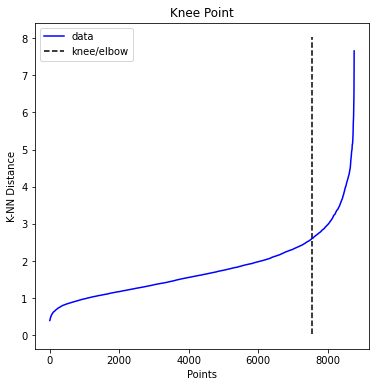

In [ ]:
kneenearest(t2mdata7)

Optimal number of min_samples based on silhouette score: [49]


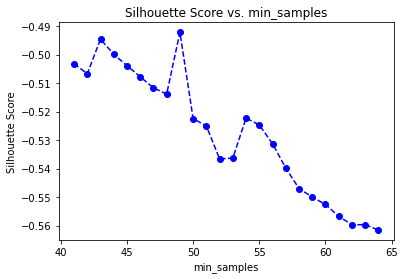

In [ ]:
# Silhouette Score for DBSCAN

def get_dbscan_score(data, center):
    '''
    
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the Silhouette Score for DBSCAN
    '''
    #instantiate kmeans
    dbscan = DBSCAN(eps=2, min_samples=center)

    # Then fit the model to your data using the fit method
    model = dbscan.fit(t2mdata7)
    
    # Calculate Silhoutte Score

    score = silhouette_score(t2mdata7, model.labels_, metric='euclidean')
    
    return score

scores = []
centers = list(range(41,65))

for center in centers:
    scores.append(get_dbscan_score(t2mdata7, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('min_samples');
plt.ylabel('Silhouette Score');
plt.title('Silhouette Score vs. min_samples');

df3 = pd.DataFrame(centers,columns=['min_samples'])
df3['scores'] = scores
df4 = df3[df3.scores == df3.scores.max()]
print('Optimal number of min_samples based on silhouette score:', df4['min_samples'].tolist())

#Conclusion

I am getting better results after I reduce the size of map in the data taking all the vairables into considereation. But when I tried taking a single variable(t2m) the results were not promising.

* Possible solution 
    * Maybe a combination of different variables or a selected variable with a reduced map size would give better results.

* Hyperparameter Tuning :
    * I felt that there was a need for trial and error method for bigger data . 
    * It’s extremely sensitive to the hyperparameters. A slight change in hyperparameters can lead to a drastic change in the outcome.

* Possible Reasons why there was no result
  * In some cases, determining an appropriate distance of neighborhood (eps) is not easy and it requires domain knowledge. If clusters are very different in terms of in-cluster densities, DBSCAN is not well suited to define clusters. 

  * This  can happen when the dataset contains clusters having different density, and the outcome you have obtained arise when the high density clusters are nested inside the low density ones.

  * A large number of points may be considered as noise due
to lack of significant neighbourhood, in terms of global 

#Possible Future Work
We can try dbscan with every other variables, or implement dimensionality reduction (PCA). 

#References


1. https://towardsdatascience.com/k-means-dbscan-gmm-agglomerative-clustering-mastering-the-popular-models-in-a-segmentation-c891a3818e29

2.   https://www.kaggle.com/code/tanmaymane18/nearestneighbors-to-find-optimal-eps-in-dbscan/notebook

3. https://medium.com/@mohantysandip/a-step-by-step-approach-to-solve-dbscan-algorithms-by-tuning-its-hyper-parameters-93e693a91289

4. https://machinelearningknowledge.ai/tutorial-for-dbscan-clustering-in-python-sklearn/

5. http://www.sefidian.com/2020/12/18/how-to-determine-epsilon-and-minpts-parameters-of-dbscan-clustering/

6. 